In [1]:
!pip install opencv-python
!pip install tensorflow
!pip install keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import cv2
import numpy as np
import imagecodecs
import tifffile as tiff 
import matplotlib.pyplot as plt
from keras import models, layers
from tensorflow.keras.optimizers.legacy import Adam

2023-04-04 21:31:39.648154: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 21:31:39.747894: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 21:31:39.750084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 21:31:41.136139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
FIMAGE_DIR = './train/images/'
FMASK_DIR = './train/gt/'
PDIM = (300, 300)
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 12

In [3]:
files = os.listdir(FIMAGE_DIR)

In [4]:
def read_tdata(files):
    x_data = []
    y_data = []
    
    for f in files:
        img = tiff.imread(FIMAGE_DIR + f)
        img = img.astype(np.float32)
        img = cv2.resize(img, PDIM)
        mask = tiff.imread(FMASK_DIR + f)
        mask = mask.astype(np.float32)
        mask = cv2.resize(mask, PDIM)
        
        x_data.append(img)
        y_data.append(mask)
    
    return np.array(x_data), np.array(y_data)

In [5]:
x_data, y_data = read_tdata(files)

In [6]:
X, Y, X_test, Y_test = x_data[:144], y_data[:144], x_data[144:], y_data[144:]

In [7]:
Y=Y/255

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f503c09d1b0>)

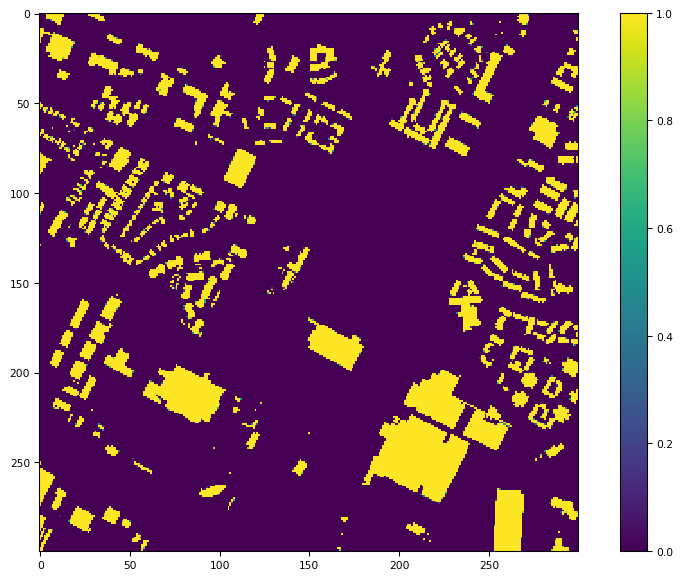

In [11]:
tiff.imshow(Y[0])

In [9]:
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

In [10]:
def build_model(img):
    in_layer = layers.Input(img.shape[1:], name = 'RGB_Input')
    pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
    pp_in_layer = layers.BatchNormalization()(pp_in_layer)

    c = conv_bn(pp_in_layer, BASE_DEPTH//2)
    c = conv_bn(c, BASE_DEPTH//2)
    c = conv_bn(c, BASE_DEPTH)

    skip_layers = [pp_in_layer]
    for j in range(BLOCK_COUNT):
        depth_steps = int(np.log2(img.shape[1])-2)
        d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                            for i in range(depth_steps)])
        d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
        d = layers.BatchNormalization()(d)
        d = layers.Activation('elu')(d)
        # bottleneck
        d = conv_bn(d, BASE_DEPTH*2**(j+1))
        skip_layers += [c]
        c = d
    d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
    d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
    d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
    seg_model = models.Model(inputs = [in_layer],
                        outputs = [d])
    return seg_model

In [11]:
model = build_model(X)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 300, 300, 3)  0          ['RGB_Input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 300, 300, 3)  12         ['gaussian_noise[0][0]']         
 alization)                                                                                       
                                                                                              

In [13]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def IoU_coeff(y_true, y_pred):
    axes = (1,2) 
    intersection = tf.keras.backend.sum(tf.math.abs(y_pred * y_true), axis=axes) 
    mask = tf.keras.backend.sum(tf.math.abs(y_true), axis=axes) + tf.keras.backend.sum(tf.math.abs(y_pred), axis=axes)
    union = mask - intersection
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [14]:
import tensorflow as tf
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_coef_loss, 
              metrics=[dice_coef, IoU_coeff])


In [15]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy='mixed_float16')
history = model.fit(X, Y, validation_split=0.25,
                    epochs=30, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/30
9/9 [==============================] - 61s 6s/step - loss: 0.7321 - dice_coef: 0.2679 - IoU_coeff: 0.1120 - val_loss: 0.7212 - val_dice_coef: 0.2788 - val_IoU_coeff: 0.1635
Epoch 2/30
9/9 [==============================] - 57s 6s/step - loss: 0.6933 - dice_coef: 0.3067 - IoU_coeff: 0.1384 - val_loss: 0.7309 - val_dice_coef: 0.2691 - val_IoU_coeff: 0.1739
Epoch 3/30
9/9 [==============================] - 57s 6s/step - loss: 0.6700 - dice_coef: 0.3300 - IoU_coeff: 0.1580 - val_loss: 0.7323 - val_dice_coef: 0.2677 - val_IoU_coeff: 0.1749
Epoch 4/30
9/9 [==============================] - 57s 6s/step - loss: 0.6572 - dice_coef: 0.3428 - IoU_coeff: 0.1673 - val_loss: 0.7300 - val_dice_coef: 0.2700 - val_IoU_coeff: 0.1757
Epoch 5/30
9/9 [==============================] - 57s 6s/step - loss: 0.6474 - dice_coef: 0.3526 - IoU_coeff: 0.1726 - val_loss: 0.7226 - val_dice_coef: 0.2774 - val_IoU_coeff: 0.1777
Epoch 6/30
9/9 [==============================] - 57s 6s/step - loss: 0.6376 - d

In [16]:
print(history.history.keys())

dict_keys(['loss', 'dice_coef', 'IoU_coeff', 'val_loss', 'val_dice_coef', 'val_IoU_coeff'])


In [17]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


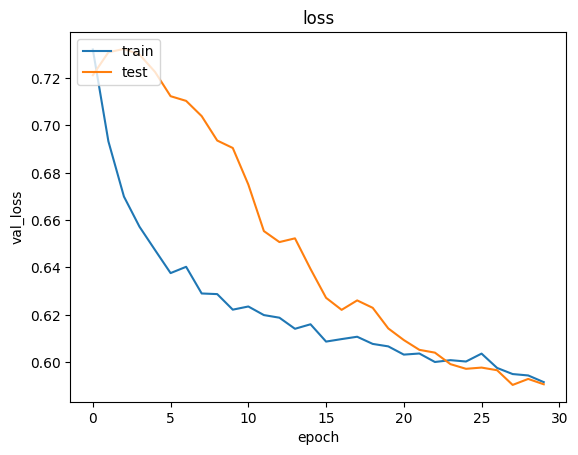

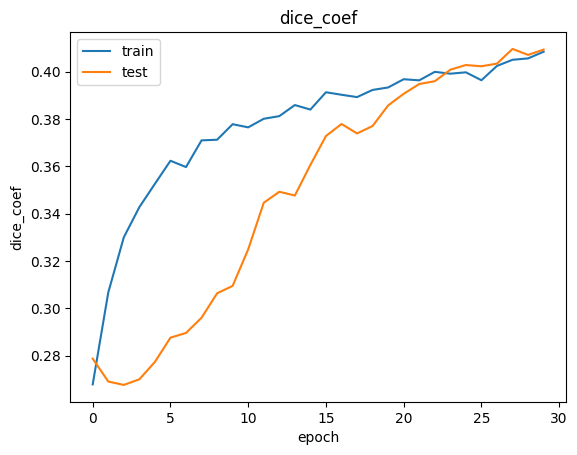

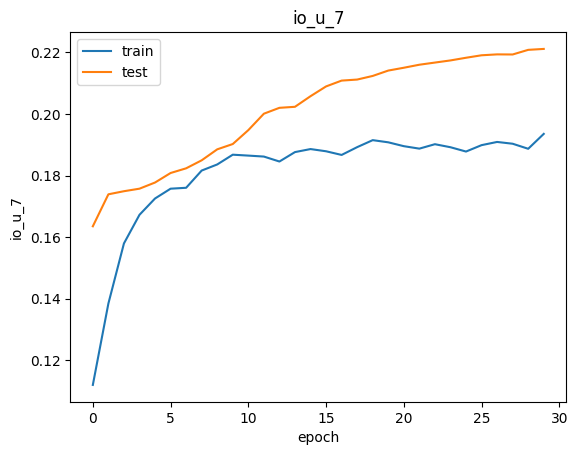

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
                         
plt.plot(history.history['IoU_coeff'])
plt.plot(history.history['val_IoU_coeff'])
plt.title('io_u_7')
plt.ylabel('io_u_7')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
scores = model.evaluate(X_test, Y_test, verbose=0)

In [22]:
scores

[0.9548822045326233, 0.0451178215444088, 1.4287832975387573]

In [24]:
print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

IoU_coeff: 142.88%


In [ ]:
json_file = open('model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("model.h5")

In [25]:
import cv2 
contours, _ = cv2.findContours(Y_test[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
polygons = []

for object in contours:
    coords = []

    for point in object:
        coords.append(int(point[0][0]))
        coords.append(int(point[0][1]))

    polygons.append(coords)

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
